In this experiment we avoid using autolog and log the training plots and the model manually. 

In [42]:
import dagshub
import mlflow
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from matplotlib import pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [43]:
mnist = tf.keras.datasets.mnist
train_data, test_data = mnist.load_data()

# Divide the data into features and labels.
train_images, train_labels = train_data
test_images, test_labels = test_data

# Reshape and normalize the images.
X_train = train_images.reshape((60000, 784))
X_train = X_train.astype('float32') / 255
X_test = test_images.reshape((10000, 784))
X_test = X_test.astype('float32') / 255

# Reshape the labels and encode them categorically.
y_train = tf.keras.utils.to_categorical(train_labels)
y_test = tf.keras.utils.to_categorical(test_labels)

# Define the sequential model.
model = tf.keras.models.Sequential()

# Add two fully-connected layers to the network.
model.add(tf.keras.layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Compile the model.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("keras_log")

<Experiment: artifact_location='file:///C:/Users/arind/Documents/mlflow/mlruns/1', creation_time=1719678968343, experiment_id='1', last_update_time=1719678968343, lifecycle_stage='active', name='keras_log', tags={}>

In [45]:
# Define the parameters.
num_epochs = 10
batch_size = 256

# Train the model.
history = model.fit(X_train,
                      y_train,
                      epochs=num_epochs,
                      batch_size=batch_size,
                      validation_data=(X_test, y_test))

Epoch 1/10
235/235 [==============================] - 2s 6ms/step - loss: 0.3287 - accuracy: 0.9074 - val_loss: 0.1643 - val_accuracy: 0.9525
Epoch 2/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1378 - accuracy: 0.9607 - val_loss: 0.1131 - val_accuracy: 0.9669
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0930 - accuracy: 0.9735 - val_loss: 0.0904 - val_accuracy: 0.9719
Epoch 4/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0681 - accuracy: 0.9803 - val_loss: 0.0802 - val_accuracy: 0.9757
Epoch 5/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0514 - accuracy: 0.9855 - val_loss: 0.0689 - val_accuracy: 0.9782
Epoch 6/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0409 - accuracy: 0.9884 - val_loss: 0.0676 - val_accuracy: 0.9784
Epoch 7/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0313 - accuracy: 0.9920 - val_loss: 0.0610 - val_accuracy: 0.9813
Epoch 

In [46]:
for metric, value in history.history.items():
    for epoch, values in enumerate(value):
        mlflow.log_metric(metric, values, step=epoch)

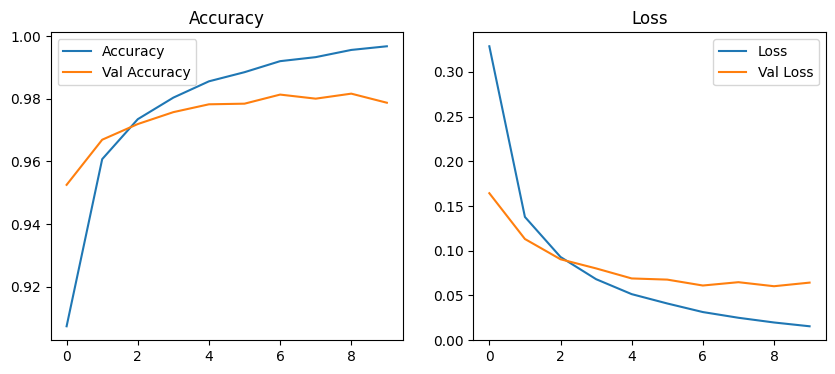

In [47]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(history.history['accuracy'], label='Accuracy' )
ax[0].plot(history.history['val_accuracy'], label='Val Accuracy' )
ax[0].set_title('Accuracy')
ax[0].legend(loc='best')
ax[1].plot(history.history['loss'], label='Loss' )
ax[1].plot(history.history['val_loss'], label='Val Loss' )
ax[1].set_title('Loss')
ax[1].legend(loc='best')

In [48]:
mlflow.log_figure(fig,'training_history.png')

In [49]:
y_test_int = np.argmax(y_test,axis = 1)
y_pred = model.predict(X_test)
y_pred_int = np.argmax(y_pred,axis = 1)

target_names = [str(i) for i in range(10)]
print(classification_report(y_test_int, y_pred_int,target_names=target_names))
clf_rpt = classification_report(y_test_int, y_pred_int,target_names=target_names, output_dict = True)


313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.96      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.99      0.97      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [50]:
conf = confusion_matrix(y_test_int, y_pred_int, labels=[i for i in range(10)])

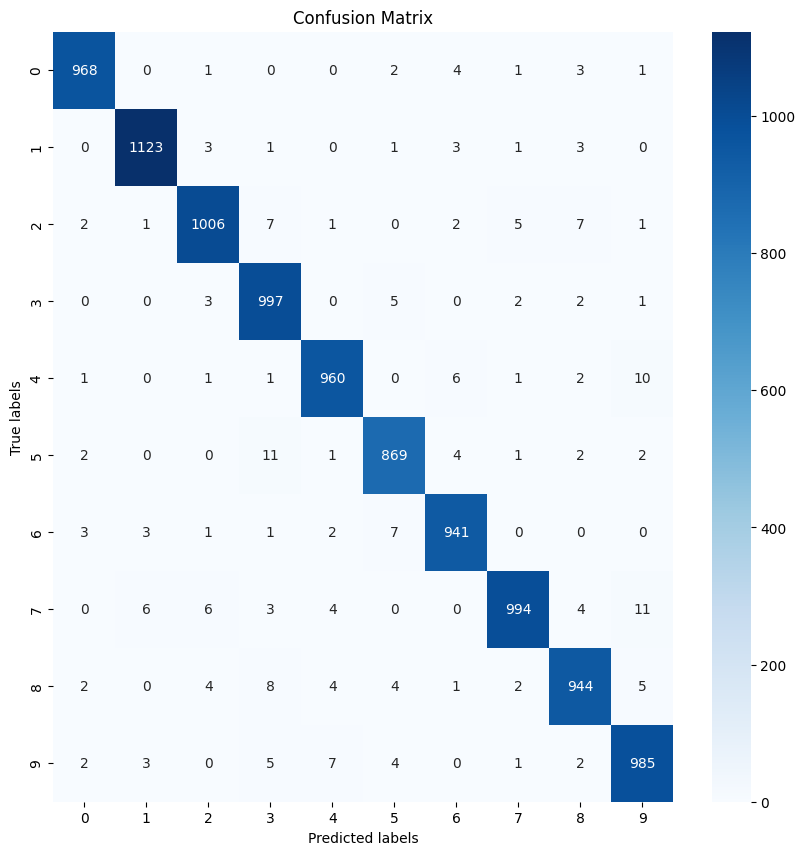

In [51]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(conf, annot=True, fmt='g', ax=ax, cmap = plt.cm.Blues);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names);
mlflow.log_figure(fig,'confusion_matrix.png')

In [52]:
mlflow.keras.log_model(model,
                       artifact_path="model",
                       registered_model_name="test_model")

2024/06/30 21:03:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\arind\AppData\Local\Temp\tmp6yv173w_\model\data\model\assets


Successfully registered model 'test_model'.
Created version '1' of model 'test_model'.


In [53]:
mlflow.end_run()